In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Generate normal sine wave data with random phase shift
def generate_sensor_data(num_samples=1000, seq_length=50, anomaly_ratio=0.1):
    X = []
    labels = []

    for _ in range(num_samples):
        phase_shift = np.random.uniform(0, 2 * np.pi)  # Random shift
        time_series = np.sin(np.linspace(0, 2 * np.pi, seq_length) + phase_shift) + 0.1 * np.random.randn(seq_length)
        label = 0  # Normal

        # Inject anomalies
        if np.random.rand() < anomaly_ratio:
            time_series += np.random.uniform(-2, 2, size=seq_length)  # Add large spikes
            label = 1  # Anomaly

        X.append(time_series)
        labels.append(label)

    return np.array(X), np.array(labels)

# Create dataset
X, y = generate_sensor_data(num_samples=2000)
X_train, X_test = torch.tensor(X[:1600], dtype=torch.float32), torch.tensor(X[1600:], dtype=torch.float32)
y_train, y_test = y[:1600], y[1600:]

# Reshape for LSTM input (batch, seq_length, features)
X_train = X_train.unsqueeze(-1)
X_test = X_test.unsqueeze(-1)

print(f"Train Data Shape: {X_train.shape}, Test Data Shape: {X_test.shape}")


Train Data Shape: torch.Size([1600, 50, 1]), Test Data Shape: torch.Size([400, 50, 1])


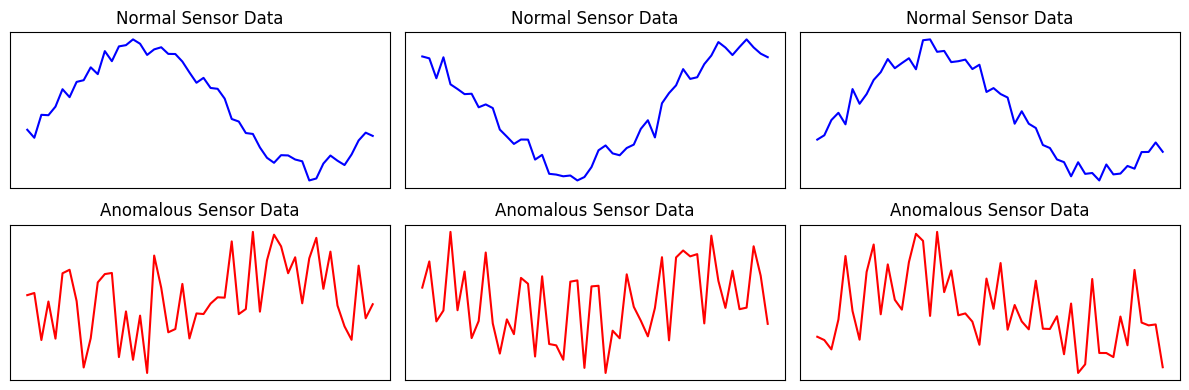

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Select a few normal and anomalous samples
normal_indices = np.where(y_train == 0)[0][:3]  # First 3 normal sequences
anomaly_indices = np.where(y_train == 1)[0][:3]  # First 3 anomalies

plt.figure(figsize=(12, 4))

# Plot normal sequences
for i, idx in enumerate(normal_indices):
    plt.subplot(2, 3, i + 1)
    plt.plot(X_train[idx].squeeze().cpu().numpy(), label="Normal", color="blue")
    plt.title("Normal Sensor Data")
    plt.xticks([]), plt.yticks([])

# Plot anomalous sequences
for i, idx in enumerate(anomaly_indices):
    plt.subplot(2, 3, i + 4)
    plt.plot(X_train[idx].squeeze().cpu().numpy(), label="Anomaly", color="red")
    plt.title("Anomalous Sensor Data")
    plt.xticks([]), plt.yticks([])

plt.tight_layout()
plt.savefig("lstm_sensor_data_samples.png", dpi=300)
plt.show()


In [3]:
import torch

# Define device for computation (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=32, num_layers=2, seq_length=50):
        super(LSTMAutoencoder, self).__init__()
        self.seq_length = seq_length
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM layers
        self.encoder = nn.LSTM(input_dim,hidden_dim, num_layers,batch_first=True)
        self.decoder = nn.LSTM(input_dim,hidden_dim, num_layers,batch_first=True)

        # Final layer to reconstruct input
        self.output_layer = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        batch_size = x.size(0)

        # Encode input
        _, (hidden, cell) = self.encoder(x)  # Correct hidden state extraction

        # Initialize decoder input as zeros
        decoder_input = torch.zeros(batch_size, self.seq_length, 1).to(x.device)

        # Decode using the last hidden state from the encoder
        decoder_output, _ = self.decoder(decoder_input, (hidden, cell))

        # Apply final layer to match original input size
        x_reconstructed = self.output_layer(decoder_output)

        return x_reconstructed  # Shape: [batch_size, seq_length, input_dim]

# Initialize model with correct sequence length
model = LSTMAutoencoder(seq_length=50).to(device)


In [4]:
# Training setup
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20
batch_size = 32

train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)

# Track loss history
loss_history = []

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        outputs = model(batch)
        loss = criterion(outputs, batch)  # Compare input and output
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    epoch_loss = total_loss / len(train_loader)
    loss_history.append(epoch_loss)  # Store epoch loss
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/20, Loss: 0.6191
Epoch 2/20, Loss: 0.3566
Epoch 3/20, Loss: 0.1433
Epoch 4/20, Loss: 0.1386
Epoch 5/20, Loss: 0.1364
Epoch 6/20, Loss: 0.1345
Epoch 7/20, Loss: 0.1339
Epoch 8/20, Loss: 0.1337
Epoch 9/20, Loss: 0.1333
Epoch 10/20, Loss: 0.1331
Epoch 11/20, Loss: 0.1331
Epoch 12/20, Loss: 0.1329
Epoch 13/20, Loss: 0.1328
Epoch 14/20, Loss: 0.1331
Epoch 15/20, Loss: 0.1327
Epoch 16/20, Loss: 0.1326
Epoch 17/20, Loss: 0.1330
Epoch 18/20, Loss: 0.1325
Epoch 19/20, Loss: 0.1328
Epoch 20/20, Loss: 0.1327


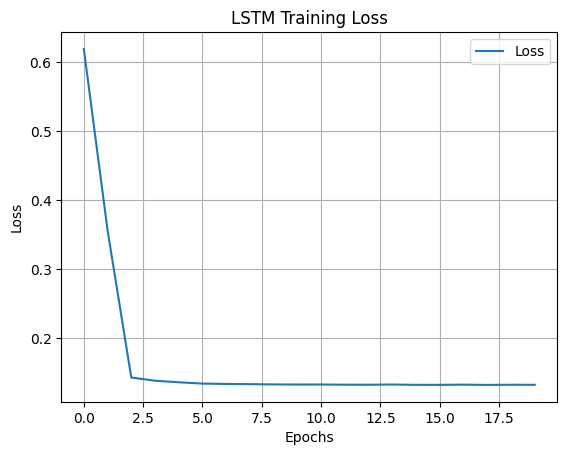

In [5]:
plt.plot(loss_history, label="Loss")
plt.xlabel("Epochs"), plt.ylabel("Loss"), plt.title("LSTM Training Loss")
plt.legend(), plt.grid(True)
plt.savefig("lstm_training_loss.png", dpi=300)
plt.show()

In [6]:
# Compute reconstruction error on test data
model.eval()
X_test = X_test.to(device)
with torch.no_grad():
    X_reconstructed = model(X_test)

reconstruction_errors = torch.mean((X_test - X_reconstructed) ** 2, dim=(1, 2)).cpu().numpy()

# Set anomaly threshold (e.g., 95th percentile)
threshold = np.percentile(reconstruction_errors, 95)
y_pred = (reconstruction_errors > threshold).astype(int)  # 1 if anomaly, else 0

# Compute detection accuracy
accuracy = np.mean(y_pred == y_test) * 100
print(f"Anomaly Detection Accuracy: {accuracy:.2f}%")


Anomaly Detection Accuracy: 94.00%


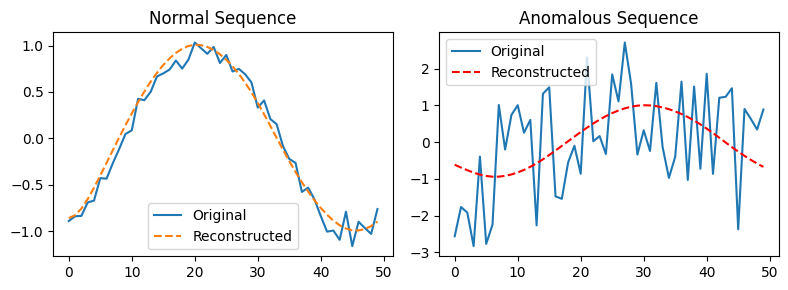

In [7]:
plt.figure(figsize=(8, 3))

# Plot normal example
plt.subplot(1, 2, 1)
plt.plot(X_test[0].cpu().numpy(), label="Original")
plt.plot(X_reconstructed[0].cpu().numpy(), label="Reconstructed", linestyle="dashed")
plt.title("Normal Sequence")
plt.legend()

# Plot anomaly example
anomaly_idx = np.argmax(reconstruction_errors)  # Most anomalous sample
plt.subplot(1, 2, 2)
plt.plot(X_test[anomaly_idx].cpu().numpy(), label="Original")
plt.plot(X_reconstructed[anomaly_idx].cpu().numpy(), label="Reconstructed", linestyle="dashed", color="red")
plt.title("Anomalous Sequence")
plt.legend()

plt.tight_layout()
plt.savefig("lstm_anomaly_detection.png", dpi=300)
plt.show()


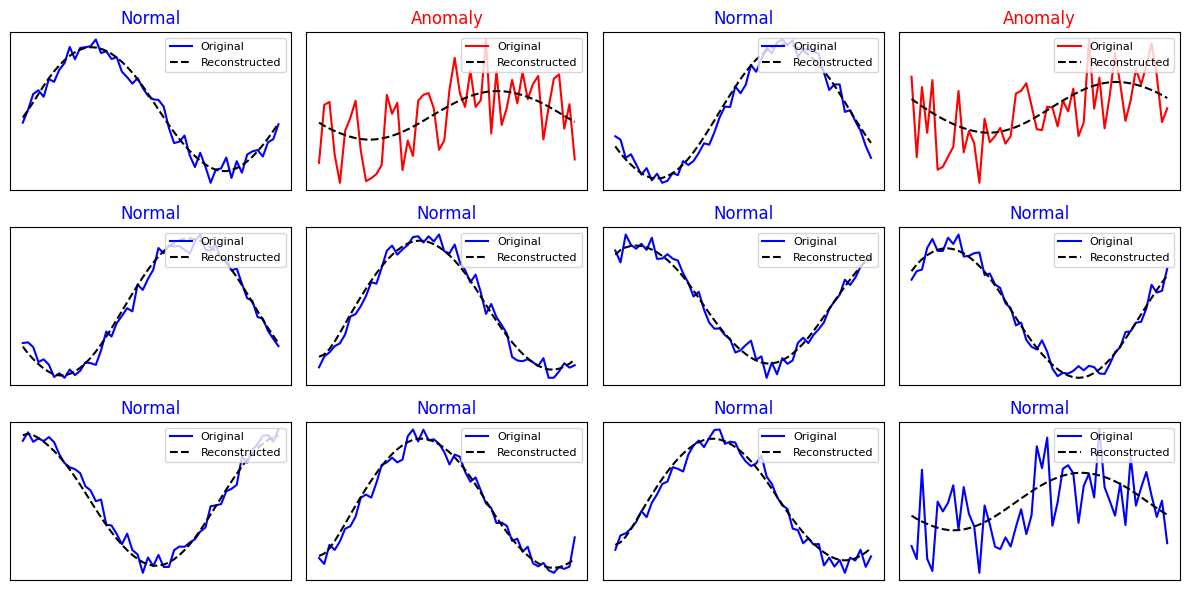

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Select 12 random test samples
num_samples = 12
indices = np.random.choice(len(X_test), num_samples, replace=False)

# Compute reconstruction errors
model.eval()
with torch.no_grad():
    X_reconstructed = model(X_test.to(device))

reconstruction_errors = torch.mean((X_test - X_reconstructed) ** 2, dim=(1, 2)).cpu().numpy()

# Detect anomalies based on threshold
threshold = np.percentile(reconstruction_errors, 90)
y_pred = (reconstruction_errors > threshold).astype(int)  # 1 = Anomaly, 0 = Normal

# Plot the selected samples
plt.figure(figsize=(12, 6))
for i, idx in enumerate(indices):
    color = 'red' if y_pred[idx] == 1 else 'blue'
    
    plt.subplot(3, 4, i + 1)
    plt.plot(X_test[idx].cpu().numpy(), color=color, label="Original")
    plt.plot(X_reconstructed[idx].cpu().numpy(), linestyle="dashed", color="black", label="Reconstructed")
    plt.title(f"{'Anomaly' if y_pred[idx] == 1 else 'Normal'}", color=color)
    plt.xticks([]), plt.yticks([])
    plt.legend(fontsize=8, loc="upper right")

plt.tight_layout()
plt.savefig("lstm_anomaly_detection_samples.png", dpi=300)
plt.show()
